# Trends and cycles in unemployment

Here we consider three methods for separating a trend and cycle in economic data. Supposing we have a time series $y_t$, the basic idea is to decompose it into these two components:

$$
y_t = \mu_t + \eta_t
$$

where $\mu_t$ represents the trend or level and $\eta_t$ represents the cyclical component. In this case, we consider a *stochastic* trend, so that $\mu_t$ is a random variable and not a deterministic function of time. Two of methods fall under the heading of "unobserved components" models, and the third is the popular Hodrick-Prescott (HP) filter. Consistent with e.g. Harvey and Jaeger (1993), we find that these models all produce similar decompositions.

This notebook demonstrates applying these models to separate trend from cycle in the U.S. unemployment rate.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
from pandas_datareader.data import DataReader
endog = DataReader('UNRATE', 'fred', start='1954-01-01')
endog.index.freq = endog.index.inferred_freq

### Hodrick-Prescott (HP) filter

The first method is the Hodrick-Prescott filter, which can be applied to a data series in a very straightforward method. Here we specify the parameter $\lambda=129600$ because the unemployment rate is observed monthly.

In [4]:
hp_cycle, hp_trend = sm.tsa.filters.hpfilter(endog, lamb=129600)

### Unobserved components and ARIMA model (UC-ARIMA)

The next method is an unobserved components model, where the trend is modeled as a random walk and the cycle is modeled with an ARIMA model - in particular, here we use an AR(4) model. The process for the time series can be written as:

$$
\begin{align}
y_t & = \mu_t + \eta_t \\
\mu_{t+1} & = \mu_t + \epsilon_{t+1} \\
\phi(L) \eta_t & = \nu_t
\end{align}
$$

where $\phi(L)$ is the AR(4) lag polynomial and $\epsilon_t$ and $\nu_t$ are white noise.

In [5]:
mod_ucarima = sm.tsa.UnobservedComponents(endog, 'rwalk', autoregressive=4)
# Here the powell method is used, since it achieves a
# higher loglikelihood than the default L-BFGS method
res_ucarima = mod_ucarima.fit(method='powell', disp=False)
print(res_ucarima.summary())

                        Unobserved Components Results                         
Dep. Variable:                 UNRATE   No. Observations:                  850
Model:                    random walk   Log Likelihood                -463.869
                              + AR(4)   AIC                            939.737
Date:                Tue, 12 Nov 2024   BIC                            968.201
Time:                        15:12:13   HQIC                           950.641
Sample:                    01-01-1954                                         
                         - 10-01-2024                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.level  8.044e-08      0.011   7.13e-06      1.000      -0.022       0.022
sigma2.ar        0.1741      0.015     11.576 

### Unobserved components with stochastic cycle (UC)

The final method is also an unobserved components model, but where the cycle is modeled explicitly.

$$
\begin{align}
y_t & = \mu_t + \eta_t \\
\mu_{t+1} & = \mu_t + \epsilon_{t+1} \\
\eta_{t+1} & = \eta_t \cos \lambda_\eta + \eta_t^* \sin \lambda_\eta + \tilde \omega_t \qquad & \tilde \omega_t \sim N(0, \sigma_{\tilde \omega}^2) \\
\eta_{t+1}^* & = -\eta_t \sin \lambda_\eta + \eta_t^* \cos \lambda_\eta + \tilde \omega_t^* & \tilde \omega_t^* \sim N(0, \sigma_{\tilde \omega}^2)
\end{align}
$$

In [6]:
mod_uc = sm.tsa.UnobservedComponents(
    endog, 'rwalk',
    cycle=True, stochastic_cycle=True, damped_cycle=True,
)
# Here the powell method gets close to the optimum
res_uc = mod_uc.fit(method='powell', disp=False)
# but to get to the highest loglikelihood we do a
# second round using the L-BFGS method.
res_uc = mod_uc.fit(res_uc.params, disp=False)
print(res_uc.summary())

                            Unobserved Components Results                            
Dep. Variable:                        UNRATE   No. Observations:                  850
Model:                           random walk   Log Likelihood                -472.641
                   + damped stochastic cycle   AIC                            953.281
Date:                       Tue, 12 Nov 2024   BIC                            972.248
Time:                               15:12:15   HQIC                           960.548
Sample:                           01-01-1954                                         
                                - 10-01-2024                                         
Covariance Type:                         opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
sigma2.level        0.0190      0.034      0.558      0.57

### Graphical comparison

The output of each of these models is an estimate of the trend component $\mu_t$ and an estimate of the cyclical component $\eta_t$. Qualitatively the estimates of trend and cycle are very similar, although the trend component from the HP filter is somewhat more variable than those from the unobserved components models. This means that relatively mode of the movement in the unemployment rate is attributed to changes in the underlying trend rather than to temporary cyclical movements.

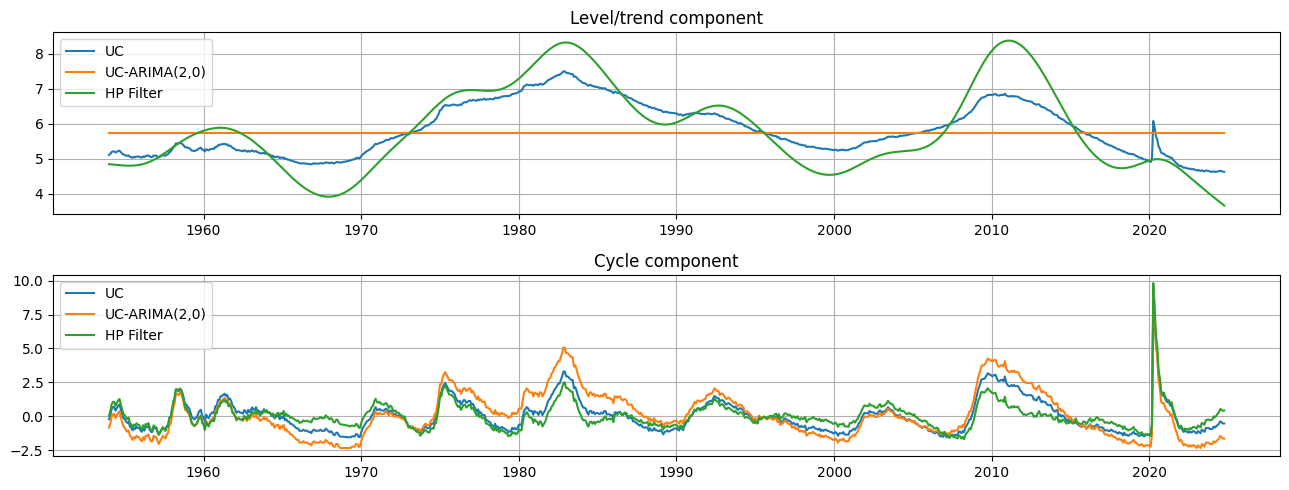

In [7]:
fig, axes = plt.subplots(2, figsize=(13,5));
axes[0].set(title='Level/trend component')
axes[0].plot(endog.index, res_uc.level.smoothed, label='UC')
axes[0].plot(endog.index, res_ucarima.level.smoothed, label='UC-ARIMA(2,0)')
axes[0].plot(hp_trend, label='HP Filter')
axes[0].legend(loc='upper left')
axes[0].grid()

axes[1].set(title='Cycle component')
axes[1].plot(endog.index, res_uc.cycle.smoothed, label='UC')
axes[1].plot(endog.index, res_ucarima.autoregressive.smoothed, label='UC-ARIMA(2,0)')
axes[1].plot(hp_cycle, label='HP Filter')
axes[1].legend(loc='upper left')
axes[1].grid()

fig.tight_layout();